# Unlocking Salary Secrets with Telco Customer Data

In [1]:
import warnings
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Tum Base Modeller
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

import matplotlib.pyplot as plt

#Uyarilari Kapat
pd.options.mode.chained_assignment = None 

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [3]:
def outlier_threshold(data, col_name, w1=0.05, w2=0.95):
    q1 = data[col_name].quantile(w1)
    q3 = data[col_name].quantile(w2)
    IQR = q3 - q1
    up = q3 + 1.5 * IQR
    low = q1 - 1.5 * IQR
    return up,low
####################################
def check_outlier(data, col_name, w1=0.05, w2=0.95):
    up, low = outlier_threshold(data, col_name, w1, w2)
    if data[(data[col_name]<low) | (data[col_name]>up)][col_name].any(axis=None):
        return True
    else:
        return False
####################################
def grab_outliers(data, col_name, index=False, w1=0.05, w2=0.95):
    up, low = outlier_threshold(data, col_name, w1, w2)
    if data[(data[col_name] < low) | (data[col_name] > up)][col_name].shape[0]>10:
        print(data[(data[col_name] < low) | (data[col_name] > up)][col_name].shape[0])
    else:
        print(data[(data[col_name] < low) | (data[col_name] > up)][col_name])
    if index:
        outlier_index = data[(data[col_name] < low) | (data[col_name] > up)][col_name].index
        return outlier_index
#####################################
def remove_outlier(data, col_name, w1, w2):
    up, low = outlier_threshold(data, col_name, w1, w2)
    df_without_outliers = data[~(data[col_name]<low)|(data[col_name]>up)]
    return df_without_outliers
######################################
def replace_with_thresholds(data, col_name, w1, w2):
    up, low = outlier_threshold(data, col_name, w1, w2)
    data[(data.col_name>up)] = up
    data[data.col_name<low] = low
######################################
def missing_values_table(data, na_name=False):
    na_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
######################################
def missing_vs_target(data, target, na_columns): #eksik değerlerin target değişken durumu
    temp_df = data.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
#######################################
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
########################################
def one_hot_encoder(data, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(data, columns=categorical_cols, drop_first=drop_first)
    return dataframe
########################################
def rare_analyser(dataframe, target, cat_cols):
     # Kategorik sütunlar otomatik olarak belirlenir, eğer sağlanmamışsa
    if cat_cols is None:
        cat_cols = [col for col in dataframe.columns if dataframe[col].dtype not in ["int", "float"]]
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}))
#######################################
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df
########################################
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
    #######################################
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
        
def check_df(dataframe):
   # Veri setinin boyutu (satır ve sütun sayısı)
    print(f"\n{'-'*50}\nDataFrame Shape: {dataframe.shape}\n{'-'*50}")
    
    # Veri türleri ve eksik değerler
    print("\nData Information (Data Types & Missing Values):")
    print(dataframe.info())
    print(f"\n{'-'*50}")
    
    # İlk birkaç gözlem
    print("\nFirst 5 Rows:")
    print(dataframe.head())
    print(f"\n{'-'*50}")
    
    # Sayısal sütunların özet istatistikleri
    print("\nDescriptive Statistics (Numerical Columns):")
    print(dataframe.describe())
    print(f"\n{'-'*50}")
    
    # Sayısal veriler için quantile değerlerini hesaplama (sadece sayısal sütunlar için)
    num_cols = dataframe.select_dtypes(include=['number']).columns
    print("\nQuantiles (0%, 5%, 50%, 95%, 99%, 100%) for Numerical Columns:")
    quantiles = dataframe[num_cols].quantile([0.000, 0.050, 0.500, 0.950, 0.990, 1.000])
    print(quantiles.transpose())
    print(f"\n{'-'*50}")
    
    # Kategorik sütunların frekansları
    print("\nCategorical Columns Value Counts:")
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    for col in cat_cols:
        print(f"\n{col} - Value Counts:")
        print(dataframe[col].value_counts())
        print(f"{'-'*50}")

######################################


In [4]:
data = pd.read_csv("hitters.csv")
df_base = data.copy() 

In [5]:
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


<Axes: >

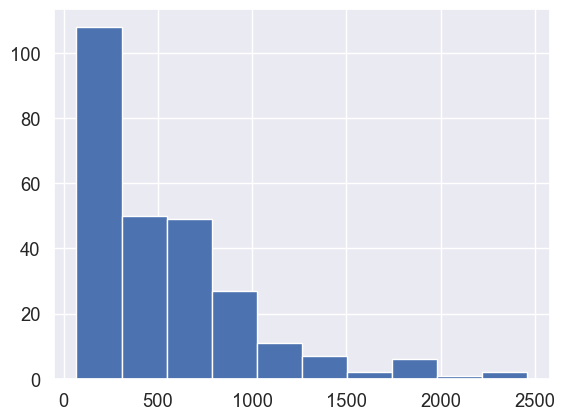

In [6]:
sns.set_theme(font_scale=1.2) 
data["Salary"].hist()

In [7]:
check_df(df_base)


--------------------------------------------------
DataFrame Shape: (322, 20)
--------------------------------------------------

Data Information (Data Types & Missing Values):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int6

In [8]:
####### BASE DATASET #######
df_base.dropna(axis=0, inplace=True)

In [9]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_base)

df_base = one_hot_encoder(df_base,cat_cols,drop_first=True)

check_df(df_base)

Observations: 263
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0

--------------------------------------------------
DataFrame Shape: (263, 20)
--------------------------------------------------

Data Information (Data Types & Missing Values):
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    int64  
 1   Hits         263 non-null    int64  
 2   HmRun        263 non-null    int64  
 3   Runs         263 non-null    int64  
 4   RBI          263 non-null    int64  
 5   Walks        263 non-null    int64  
 6   Years        263 non-null    int64  
 7   CAtBat       263 non-null    int64  
 8   CHits        263 non-null    int64  
 9   CHmRun       263 non-null    int64  
 10  CRuns        263 non-null    int64  
 11  CRBI         263 non-null    int64  
 12  CWalks       263 non-null    int64  
 13 

In [10]:
# Standart Scaler
scaled_cols = [col for col in df_base.columns if col != "Salary"]
scaler = StandardScaler()
df_base[scaled_cols] = scaler.fit_transform(df_base[scaled_cols])

# Base model Kurulumu
X = df_base.drop("Salary",axis=1)
y = df_base[["Salary"]]

X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

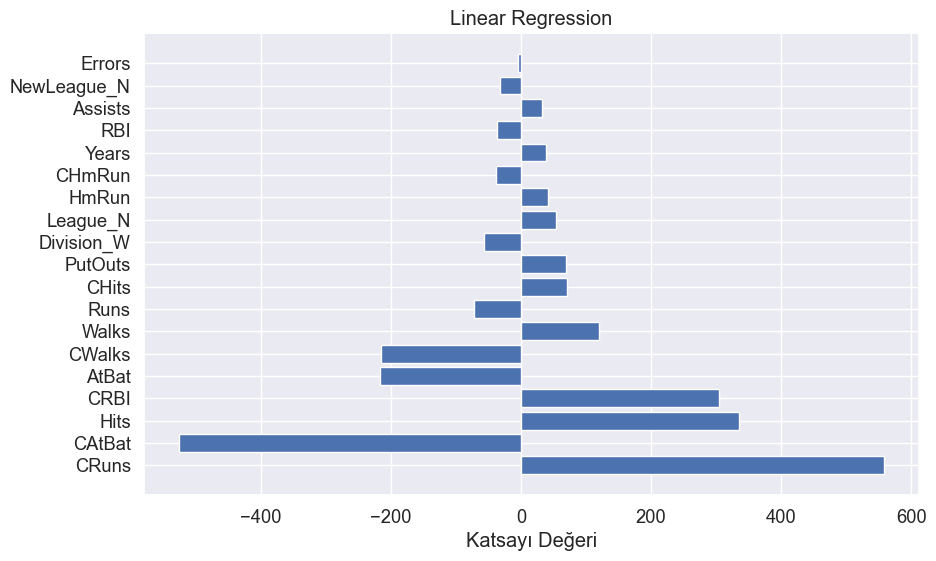

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_importance_linear_reg(model, X_train):
    # Katsayıları al
    importance = model.coef_.flatten()  # .flatten() ile katsayıları tek boyutlu diziye çeviriyoruz
    
    # Özelliklerin isimlerini al (varsa)
    feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])
    
    # Önem sırasına göre sıralama
    sorted_idx = np.argsort(np.abs(importance))[::-1]
    
    # Grafiği oluştur
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Katsayı Değeri')
    plt.title('Linear Regression')
    plt.show()

# Fonksiyonu çağırmak için:

# Linear Regression
lr_base = LinearRegression().fit(X_train, y_train)
y_base_lr_pred = lr_base.predict(X_test)

df_base["Salary"].mean()

base_lr_error = np.sqrt(mean_squared_error(y_test, y_base_lr_pred))

plot_importance_linear_reg(lr_base, X_train)


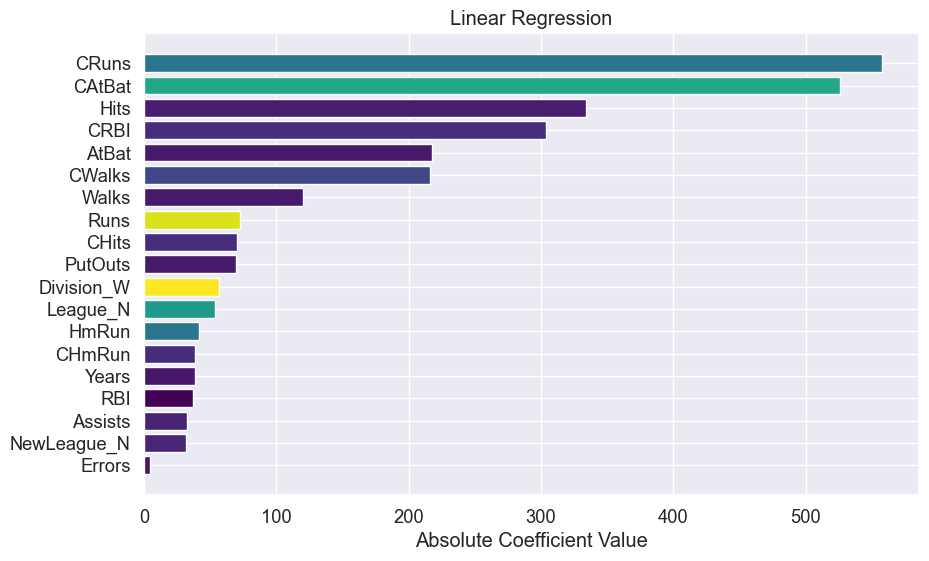

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm

def plot_importance_linear_reg(model, X_train):
    # Katsayıları ve özellik isimlerini al
    importance = np.abs(model.coef_.flatten())  # Mutlak değerini alıyoruz
    feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])
    
    # Özellikler ve önem derecelerini bir DataFrame'e koy ve önem sırasına göre sırala
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by="Importance", ascending=False)
    
    # Renk tonlarını belirle (koyu renkten açığa doğru)
    colors = cm.viridis(importance / max(importance))  # En yüksek önem değerine göre normalizasyon

    # Grafiği oluştur
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
    plt.xlabel("Absolute Coefficient Value")
    plt.title("Linear Regression")
    plt.gca().invert_yaxis()  # En önemli özellik üstte olacak şekilde ters çevir
    plt.show()

# Fonksiyonu çağırmak için:
plot_importance_linear_reg(lr_base, X_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 19
[LightGBM] [Info] Start training from score 543.664624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

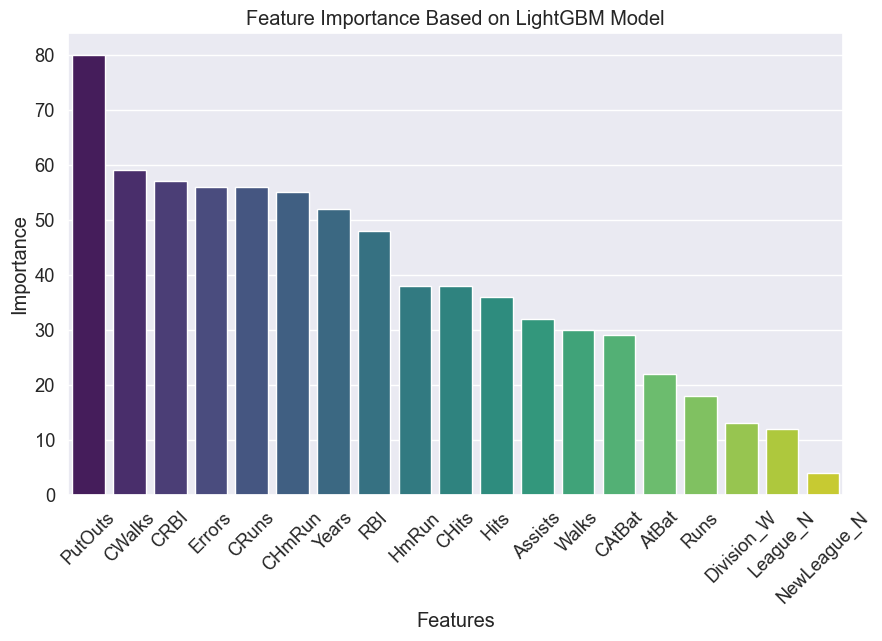

In [13]:
def plot_bar_importance(model, X):
    # Modelin özellik önemlerini al
    feature_importances = model.feature_importances_

    # Özellik isimlerini al
    features = X.columns

    # Özellikler ve önem derecelerini birleştirip bir DataFrame oluştur
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    })

    # Özellikleri önem derecelerine göre sıralama
    importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

    # Sıralanmış özellikleri ve önem derecelerini al
    sorted_features = importance_df_sorted['Feature']
    sorted_importances = importance_df_sorted['Importance']

    # Bar grafiği çizme
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_features, y=sorted_importances, palette='viridis')

    # Başlık ve etiketler
    plt.title('Feature Importance Based on LightGBM Model')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)

    plt.show()

# Kullanım örneği:
lgbm_base = LGBMRegressor(random_state=42).fit(X_train, y_train)
y_base_lgbm_pred = lgbm_base.predict(X_test)

base_lgbm_error = np.sqrt(mean_squared_error(y_test, y_base_lgbm_pred))

# Özniteliklerin önem derecelerini görselleştirme
plot_bar_importance(lgbm_base, X_train)


In [14]:
# Final Model Kurulumu
df = data.copy()

# Kategorik Değişken Analizi
rare_analyser(df,"Salary",cat_cols)

League : 2
        COUNT  RATIO  TARGET_MEAN
League                           
A         175  0.543      542.000
N         147  0.457      529.118
Division : 2
          COUNT  RATIO  TARGET_MEAN
Division                           
E           157  0.488      624.271
W           165  0.512      450.877
NewLeague : 2
           COUNT  RATIO  TARGET_MEAN
NewLeague                           
A            176  0.547      537.113
N            146  0.453      534.554


count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64


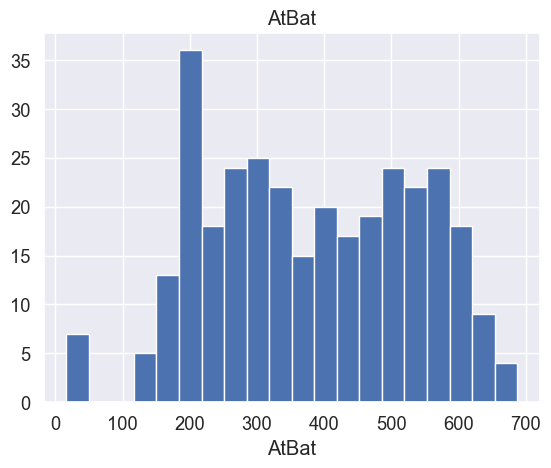

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64


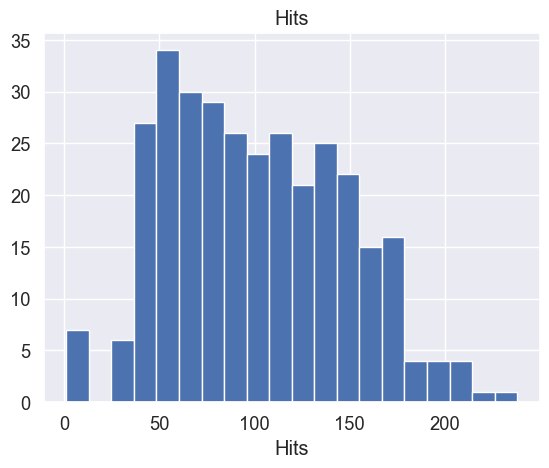

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64


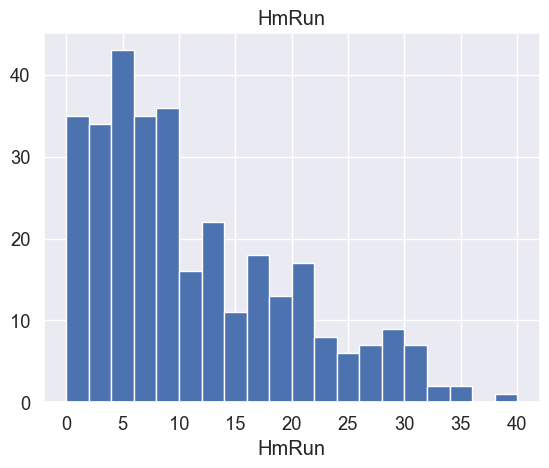

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20%      27.000
30%      33.000
40%      41.000
50%      48.000
60%      55.600
70%      66.000
80%      75.800
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64


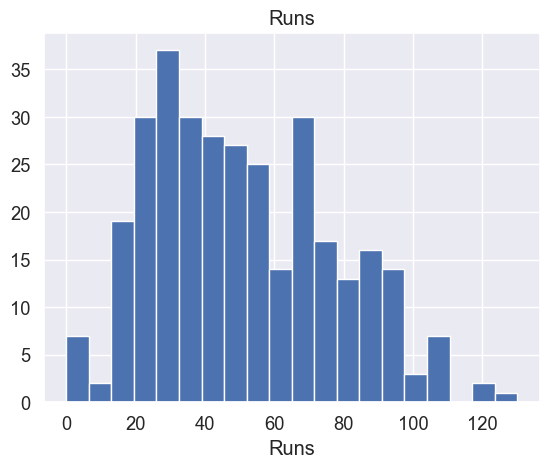

count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
20%      26.000
30%      30.000
40%      36.400
50%      44.000
60%      49.000
70%      58.000
80%      73.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI, dtype: float64


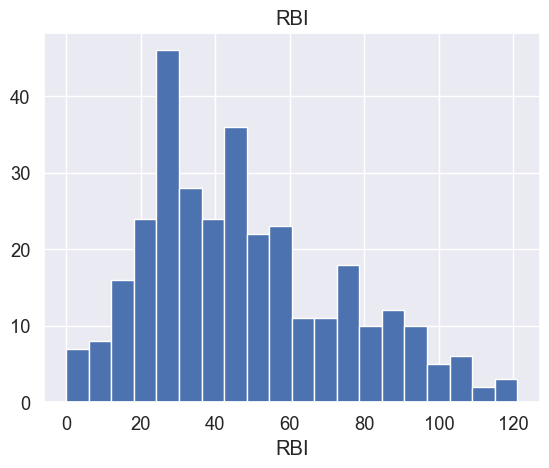

count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
20%      20.000
30%      24.000
40%      30.000
50%      35.000
60%      40.000
70%      48.700
80%      59.000
90%      69.900
95%      78.000
99%      93.580
max     105.000
Name: Walks, dtype: float64


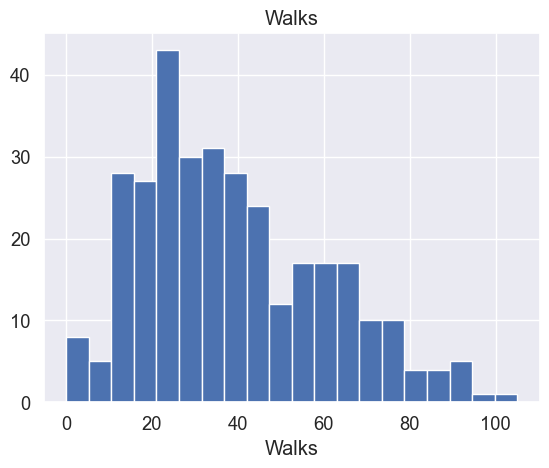

count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       7.600
70%      10.000
80%      12.000
90%      15.000
95%      17.000
99%      19.790
max      24.000
Name: Years, dtype: float64


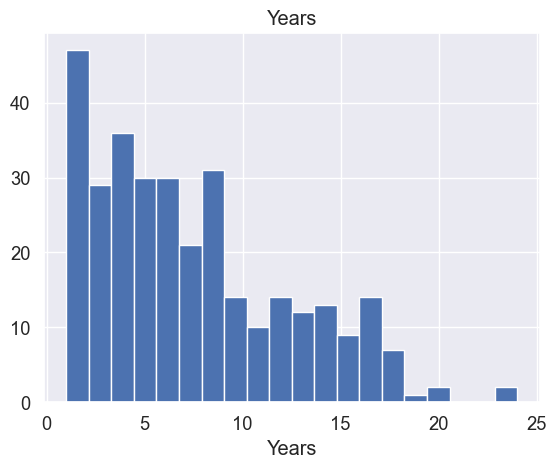

count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
20%       667.600
30%       963.400
40%      1402.200
50%      1928.000
60%      2654.000
70%      3365.000
80%      4483.000
90%      6123.400
95%      7125.600
99%      8749.970
max     14053.000
Name: CAtBat, dtype: float64


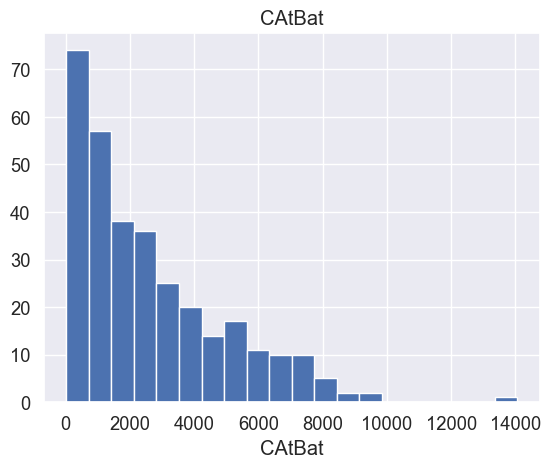

count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
20%      164.600
30%      238.000
40%      355.800
50%      508.000
60%      708.200
70%      911.100
80%     1229.200
90%     1659.600
95%     2017.150
99%     2500.340
max     4256.000
Name: CHits, dtype: float64


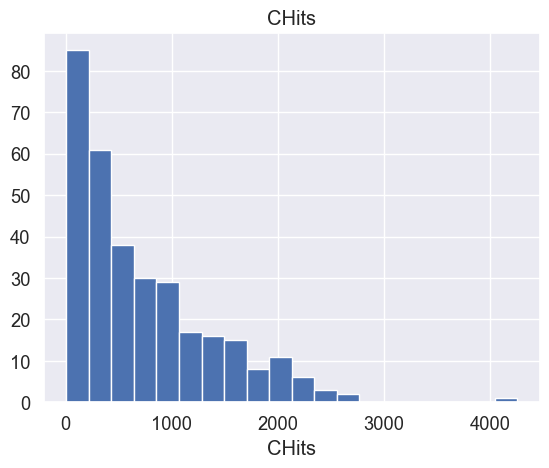

count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
20%      10.200
30%      16.300
40%      27.400
50%      37.500
60%      51.200
70%      72.400
80%     103.800
90%     194.900
95%     265.650
99%     373.120
max     548.000
Name: CHmRun, dtype: float64


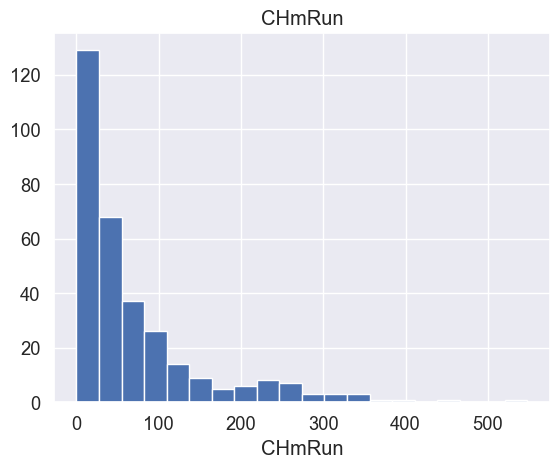

count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
20%       80.400
30%      117.300
40%      181.000
50%      247.000
60%      333.000
70%      443.400
80%      627.200
90%      895.700
95%     1032.300
99%     1174.370
max     2165.000
Name: CRuns, dtype: float64


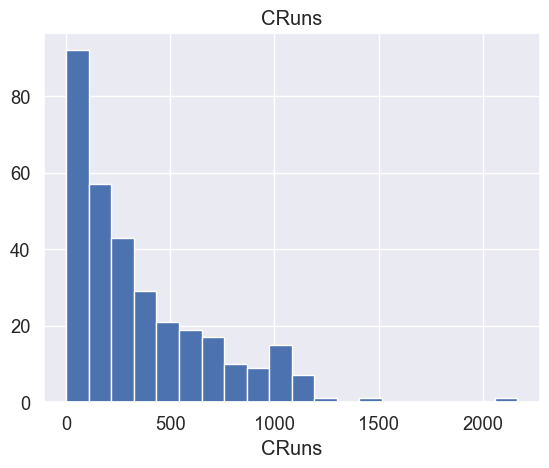

count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
20%       70.200
30%      106.300
40%      149.000
50%      220.500
60%      303.600
70%      379.100
80%      496.200
90%      861.600
95%     1071.750
99%     1310.850
max     1659.000
Name: CRBI, dtype: float64


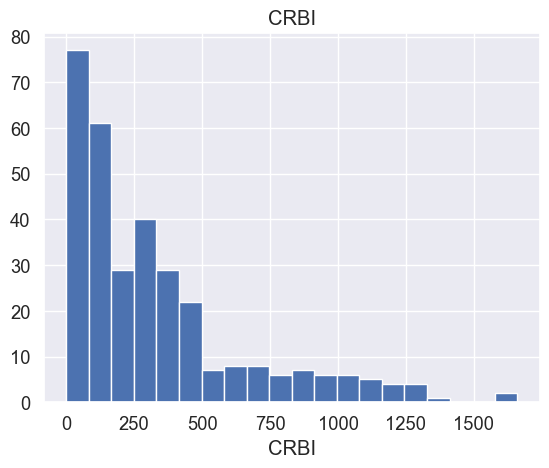

count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
20%       55.000
30%       82.000
40%      117.400
50%      170.500
60%      226.600
70%      300.700
80%      421.000
90%      643.900
95%      817.600
99%     1139.140
max     1566.000
Name: CWalks, dtype: float64


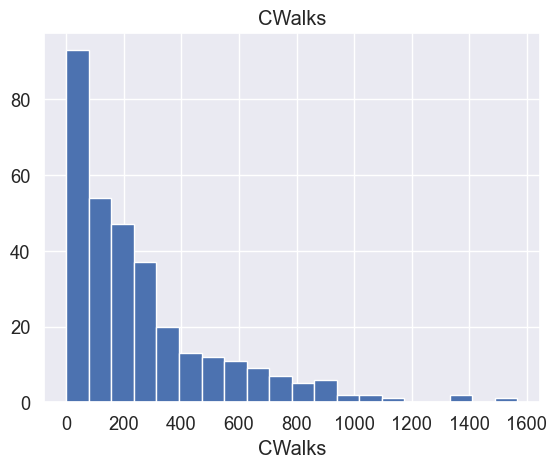

count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
20%       99.600
30%      132.000
40%      167.000
50%      212.000
60%      257.400
70%      303.000
80%      365.800
90%      685.600
95%      910.650
99%     1301.190
max     1378.000
Name: PutOuts, dtype: float64


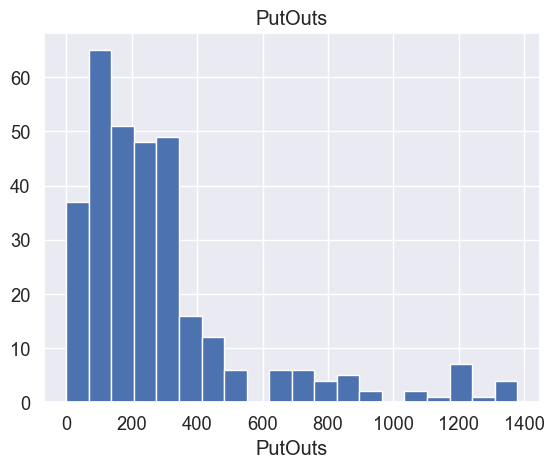

count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
20%       5.200
30%       9.000
40%      15.400
50%      39.500
60%      76.800
70%     134.800
80%     210.800
90%     353.300
95%     431.450
99%     478.160
max     492.000
Name: Assists, dtype: float64


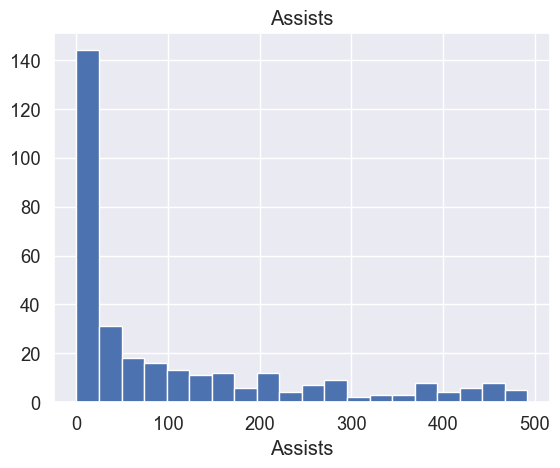

count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       8.000
70%      10.000
80%      13.000
90%      17.000
95%      20.000
99%      25.790
max      32.000
Name: Errors, dtype: float64


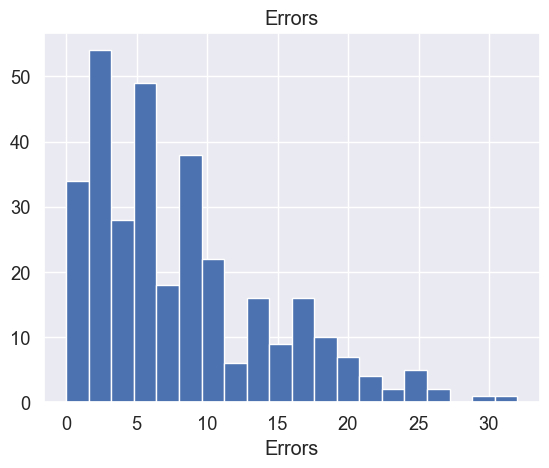

count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
20%      155.000
30%      221.000
40%      300.000
50%      425.000
60%      538.000
70%      700.000
80%      809.000
90%     1048.667
95%     1346.000
99%     2032.887
max     2460.000
Name: Salary, dtype: float64


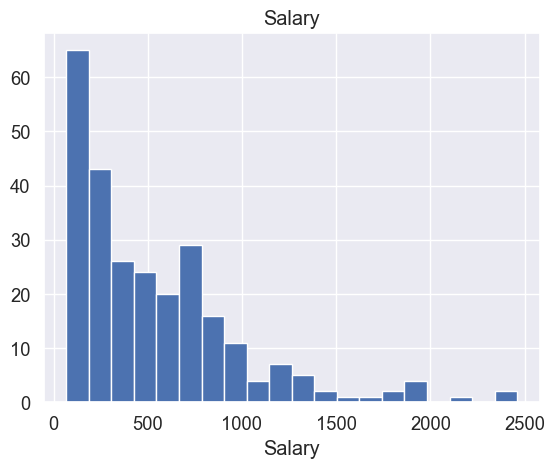

In [15]:
# Sayısal Değişken Analizi
for col in num_cols:
    num_summary(df, col, plot=True)

In [16]:
# Outlier Analizi
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


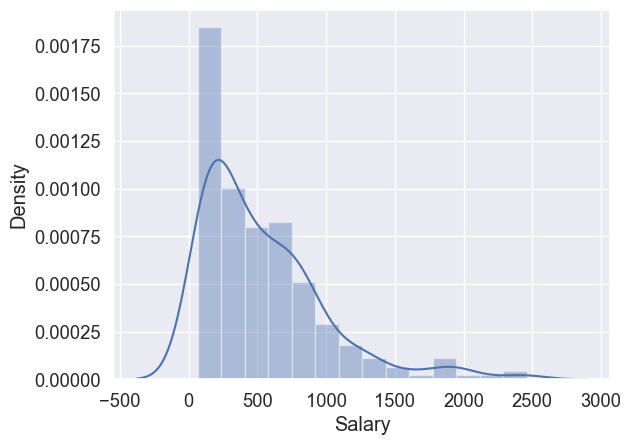

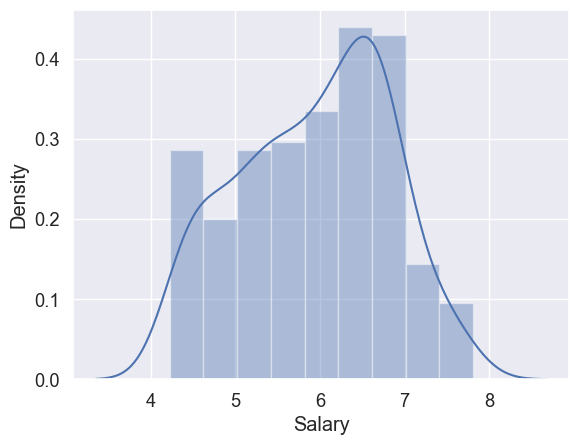

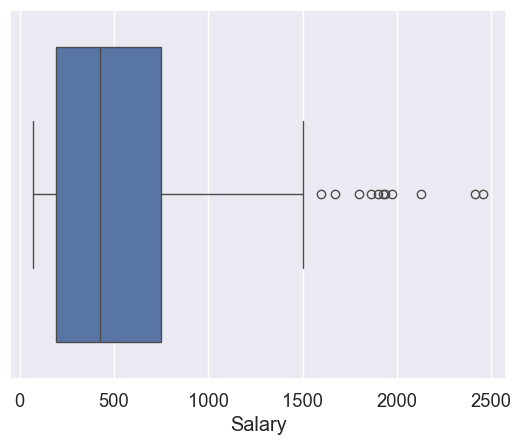

(322, 20)


(308, 20)

In [17]:
# Bağımlı Değişken Analizi
df["Salary"].describe()
sns.distplot(df["Salary"])
plt.show()

sns.distplot(np.log1p(df["Salary"]))
plt.show()

sns.boxplot(x=df["Salary"])
plt.show()

# 1350 den sonraki değerleri veri setinden çıkartıyorum.

print(df.shape)
df = df[(df["Salary"] < 1350) | (df["Salary"].isnull())]
df.shape

In [18]:
# Aykırı Değerleri Baskılama
a=0
for col in num_cols:
    a +=1
    if check_outlier(df,col):
        replace_with_thresholds(df,col)
print(f"Tespit Edilen Outlier : {a} adet baskılanmıştır")
check_df(df)

Tespit Edilen Outlier : 17 adet baskılanmıştır

--------------------------------------------------
DataFrame Shape: (308, 20)
--------------------------------------------------

Data Information (Data Types & Missing Values):
<class 'pandas.core.frame.DataFrame'>
Index: 308 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      308 non-null    int64  
 1   Hits       308 non-null    int64  
 2   HmRun      308 non-null    int64  
 3   Runs       308 non-null    int64  
 4   RBI        308 non-null    int64  
 5   Walks      308 non-null    int64  
 6   Years      308 non-null    int64  
 7   CAtBat     308 non-null    int64  
 8   CHits      308 non-null    int64  
 9   CHmRun     308 non-null    int64  
 10  CRuns      308 non-null    int64  
 11  CRBI       308 non-null    int64  
 12  CWalks     308 non-null    int64  
 13  League     308 non-null    object 
 14  Division   308 non-null    ob

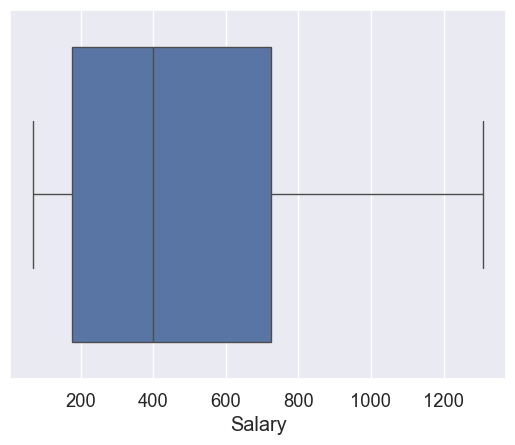

In [19]:
sns.boxplot(x=df["Salary"])
plt.show()

In [20]:
# Eksik Gözlem Analizi

missing_values_table(df)

        n_miss  ratio
Salary      59 19.160


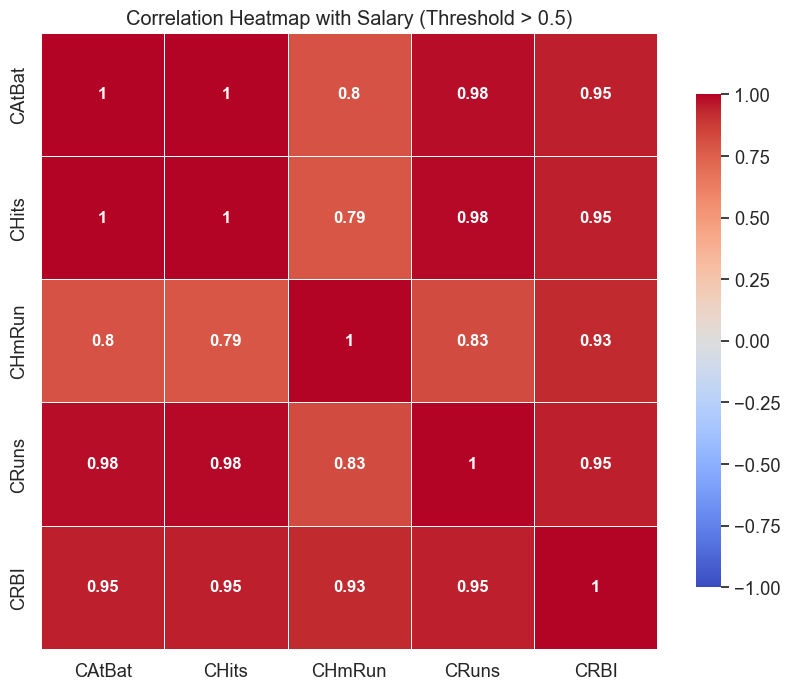

In [21]:
def target_correlation_matrix(df, corr_th, target="Salary"):
    # Korelasyon matrisini hesapla
    corr_matrix = df.corr()
    
    # Hedef değişkenle olan korelasyonları al
    target_corr = corr_matrix[target].drop(target)  # Hedefi dışarda bırak
    
    # Korelasyonu belirli bir eşik değeri ile filtrele
    #filtered_corr = target_corr[abs(target_corr) >= corr_th]
    filtered_corr = target_corr[target_corr >= corr_th]

 

    # Eğer hiçbir özellik yeterince güçlü korelasyona sahip değilse
    if filtered_corr.empty:
        print(f"No features have a correlation above {corr_th} with the target.")
        return
    
    # Korelasyon matrisini sadece filtrelenmiş özelliklerle oluştur
    # Tüm özellikler arasındaki korelasyonu hedefle görselleştir
    filtered_corr_matrix = corr_matrix.loc[filtered_corr.index, filtered_corr.index]
    
    # Kareli Heatmap'i oluştur
    plt.figure(figsize=(10, 8))  # Grafik boyutunu ayarlayalım
    sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm", cbar=True, linewidths=0.5,
                square=True, vmin=-1, vmax=1, annot_kws={"size": 12, "weight": "bold"}, cbar_kws={'shrink': 0.8})
    plt.title(f'Correlation Heatmap with {target} (Threshold > {corr_th})')
    plt.show()

# Fonksiyonu çağırmak için:
target_correlation_matrix(df_base, corr_th=0.5, target="Salary")


In [22]:
# Feature Engineering
df['NEW_HitRatio'] = df['Hits'] / df['AtBat']
df['NEW_RunRatio'] = df['HmRun'] / df['Runs']
df['NEW_CHitRatio'] = df['CHits'] / df['CAtBat']
df['NEW_CRunRatio'] = df['CHmRun'] / df['CRuns']

df['NEW_Avg_AtBat'] = df['CAtBat'] / df['Years']
df['NEW_Avg_Hits'] = df['CHits'] / df['Years']
df['NEW_Avg_HmRun'] = df['CHmRun'] / df['Years']
df['NEW_Avg_Runs'] = df['CRuns'] / df['Years']
df['NEW_Avg_RBI'] = df['CRBI'] / df['Years']
df['NEW_Avg_Walks'] = df['CWalks'] / df['Years']

In [23]:
df.shape

(308, 30)

In [24]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,NEW_HitRatio,NEW_RunRatio,NEW_CHitRatio,NEW_CRunRatio,NEW_Avg_AtBat,NEW_Avg_Hits,NEW_Avg_HmRun,NEW_Avg_Runs,NEW_Avg_RBI,NEW_Avg_Walks
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A,0.225,0.033,0.225,0.033,293.000,66.000,1.000,30.000,29.000,14.000
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N,0.257,0.292,0.242,0.215,246.357,59.643,4.929,22.929,29.571,26.786
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A,0.271,0.273,0.281,0.281,541.333,152.333,21.000,74.667,88.667,87.667
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N,0.284,0.308,0.280,0.272,511.636,143.182,20.455,75.273,76.182,32.182
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N,0.271,0.256,0.255,0.250,198.000,50.500,6.000,24.000,23.000,16.500


In [25]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [26]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_HitRatio,NEW_RunRatio,NEW_CHitRatio,NEW_CRunRatio,NEW_Avg_AtBat,NEW_Avg_Hits,NEW_Avg_HmRun,NEW_Avg_Runs,NEW_Avg_RBI,NEW_Avg_Walks,League_N,Division_W,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,NaN,0.225,0.033,0.225,0.033,293.000,66.000,1.000,30.000,29.000,14.000,False,False,False
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.000,0.257,0.292,0.242,0.215,246.357,59.643,4.929,22.929,29.571,26.786,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.000,0.271,0.273,0.281,0.281,541.333,152.333,21.000,74.667,88.667,87.667,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.000,0.284,0.308,0.280,0.272,511.636,143.182,20.455,75.273,76.182,32.182,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.500,0.271,0.256,0.255,0.250,198.000,50.500,6.000,24.000,23.000,16.500,True,False,True


In [27]:
# Modelleme 
df_null = df[df["Salary"].isnull()]
df.dropna(inplace=True)
df.shape

(249, 30)

In [28]:
# # STANDARD SCALER:
##########################
scaled_cols = [col for col in df.columns if col != "Salary"]
scaler = StandardScaler()
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

y = df[['Salary']]
X = df.drop("Salary", axis=1)

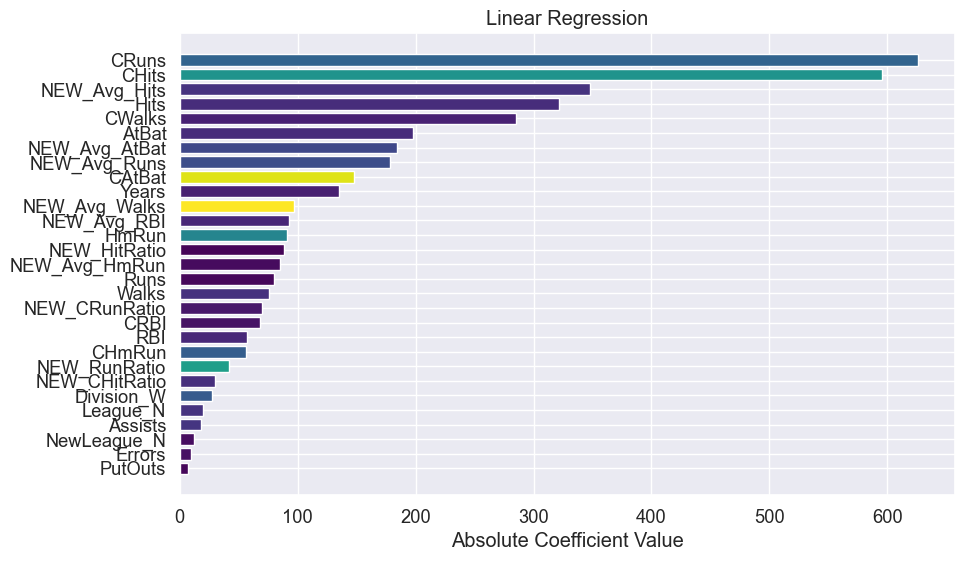

In [29]:
# HOLD OUT - MODEL VALIDATION
##########################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Linear Regression after Feat. Eng.
lr_model = LinearRegression().fit(X_train, y_train)
y_lr_pred = lr_model.predict(X_test)

lr_model_base_error = np.sqrt(mean_squared_error(y_test, y_lr_pred))

plot_importance_linear_reg(lr_model, X_train)

In [30]:
# LGBM Regression after Feat Eng.
lgbm_model = LGBMRegressor(random_state=42).fit(X_train, y_train)
y_lgbm_pred = lgbm_model.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_lgbm_pred))
lgbm_model_base_error = np.sqrt(mean_squared_error(y_test, y_lgbm_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 29
[LightGBM] [Info] Start training from score 474.866000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

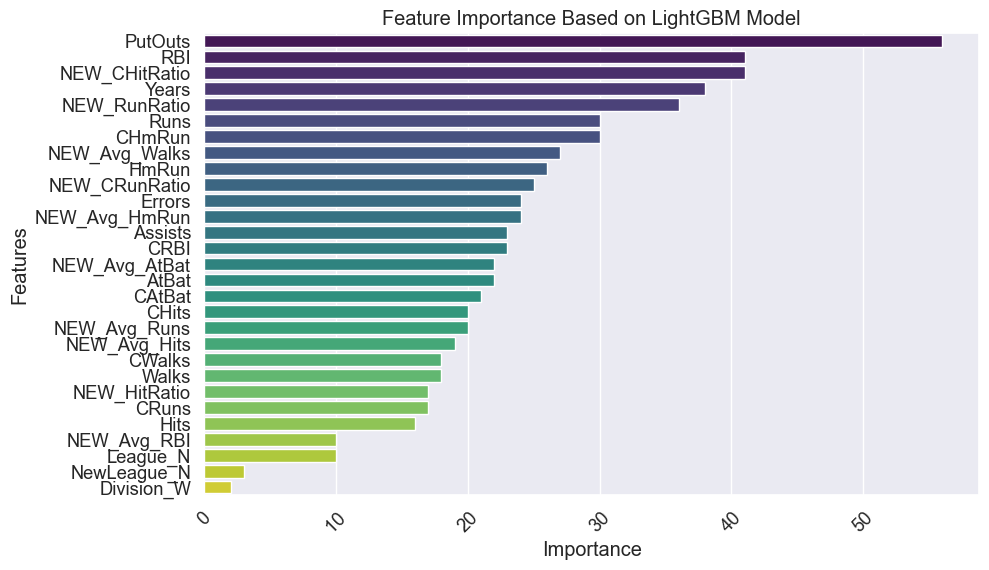

In [31]:
def plot_bar_importance2(model, X, orientation='horizontal'):
    # Modelin özellik önemlerini al
    feature_importances = model.feature_importances_

    # Özellik isimlerini al
    features = X.columns

    # Özellikler ve önem derecelerini birleştirip bir DataFrame oluştur
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    })

    # Özellikleri önem derecelerine göre sıralama
    importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

    # Sıralanmış özellikleri ve önem derecelerini al
    sorted_features = importance_df_sorted['Feature']
    sorted_importances = importance_df_sorted['Importance']

    # Grafik yönü kontrolü: 'horizontal' veya 'vertical'
    if orientation == 'horizontal':
        # Yatay bar grafiği çizme
        plt.figure(figsize=(10, 6))
        sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis')
        plt.xlabel('Importance')
        plt.ylabel('Features')
    else:
        # Dikey bar grafiği çizme
        plt.figure(figsize=(10, 6))
        sns.barplot(x=sorted_features, y=sorted_importances, palette='viridis')
        plt.ylabel('Importance')
        plt.xlabel('Features')
    
    # Başlık ve etiketler
    plt.title('Feature Importance Based on LightGBM Model')
    plt.xticks(rotation=45)
    
    plt.show()

plot_bar_importance2(lgbm_model, X_train, orientation='horizontal')


Fitting 10 folds for each of 81 candidates, totalling 810 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 29
[LightGBM] [Info] Start training from score 474.866000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

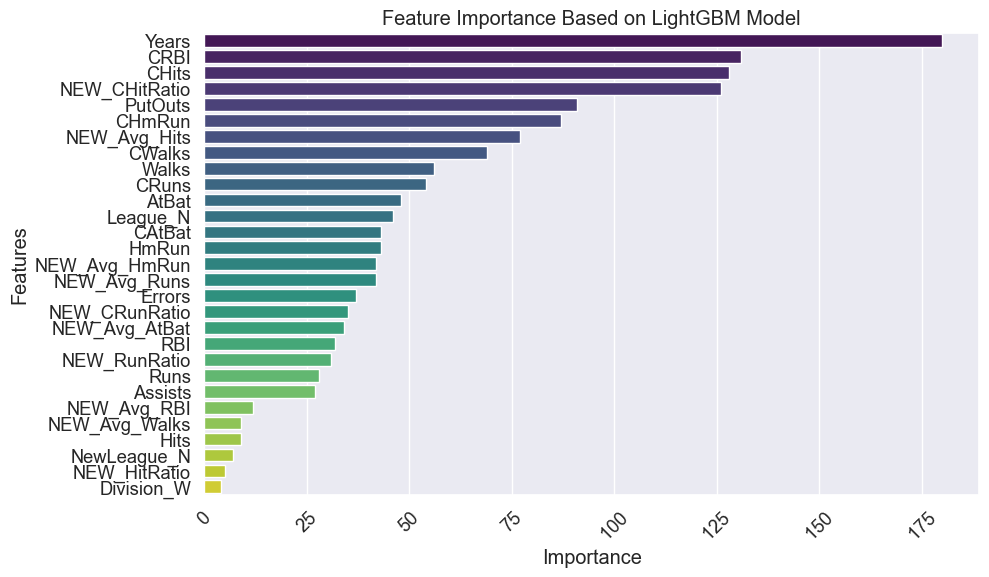

In [32]:
lgbm_params = {
    'n_estimators': [100, 200, 300],  # Farklı sayıda ağaç
    'learning_rate': [0.01, 0.05, 0.1],  # Öğrenme oranları
    'max_depth': [3, 5, 7],  # Ağacın derinliği
    'num_leaves': [31, 50, 70]  # Yaprak sayısı
}
lgbm_cv = GridSearchCV(lgbm_model, lgbm_params,cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
lgbm_cv.best_params_

final_model = LGBMRegressor(random_state=42, **lgbm_cv.best_params_).fit(X_train, y_train)
y_final_pred = final_model.predict(X_test)

final_model_error = np.sqrt(mean_squared_error(y_test, y_final_pred))


plot_bar_importance2(final_model, X_train,orientation='horizontal')

In [33]:
# SALARYDEKİ NA DEĞERLERİN TAHMİNİ İLE BİRLİKTE MODEL KURMA
df_null.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_HitRatio,NEW_RunRatio,NEW_CHitRatio,NEW_CRunRatio,NEW_Avg_AtBat,NEW_Avg_Hits,NEW_Avg_HmRun,NEW_Avg_Runs,NEW_Avg_RBI,NEW_Avg_Walks,League_N,Division_W,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,NaN,0.225,0.033,0.225,0.033,293.000,66.000,1.000,30.000,29.000,14.000,False,False,False
15,183,39,3,20,15,11,3,201,42,3,20,16,11,118,0,0,NaN,0.213,0.150,0.209,0.150,67.000,14.000,1.000,6.667,5.333,3.667,False,True,False
18,407,104,6,57,43,65,12,5233,1478,100,643,658,653,912,88,9,NaN,0.256,0.105,0.282,0.156,436.083,123.167,8.333,53.583,54.833,54.417,False,True,False
22,22,10,1,4,2,1,6,84,26,2,9,9,3,812,84,11,NaN,0.455,0.250,0.310,0.222,14.000,4.333,0.333,1.500,1.500,0.500,False,True,False
30,313,84,9,42,30,39,17,6890,1833,224,1033,864,1087,127,221,7,NaN,0.268,0.214,0.266,0.217,405.294,107.824,13.176,60.765,50.824,63.941,False,True,False


In [34]:
df_null.drop("Salary",axis=1,inplace=True)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 29
[LightGBM] [Info] Start training from score 474.866000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

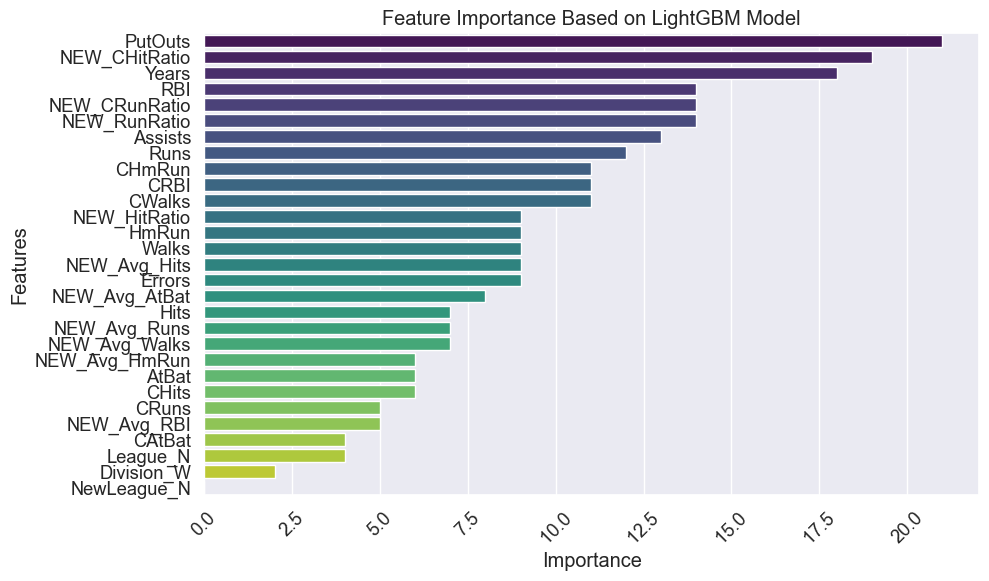

In [35]:
final_null_model = LGBMRegressor(random_state=42)

lgbm_params = {
   'n_estimators': [40, 90, 110],  # Ağaç sayısını artırma
    'learning_rate': [0.2, 0.25],  # Yüksek öğrenme oranları
    'max_depth': [7, 9],  # Ağaç derinliğini biraz daha artırma
    'num_leaves': [30, 50],  # Orta seviyede yaprak sayısı
}
null_cv = GridSearchCV(final_null_model, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

null_tuned_model = LGBMRegressor(random_state=42, **null_cv.best_params_).fit(X_train, y_train)

y_pred_null = null_tuned_model.predict(X_test)
null_tuned_model_error = np.sqrt(mean_squared_error(y_test, y_pred_null))
null_tuned_model_error
y_train.shape

plot_bar_importance2(null_tuned_model, X_train,orientation='horizontal')

In [36]:
null_tuned_model_error

155.5637019277183

In [37]:
score_df = pd.DataFrame(index=["LR Base Error", "LGBM BASE ERROR", "LR Error After Feat. Eng.", "LGBM Error After Feat. Eng.", "LGBM Final Model Error", "LGBM Null Model Error"], data=[base_lr_error, base_lgbm_error, lr_model_base_error, lgbm_model_base_error, final_model_error, null_tuned_model_error], columns= ["RMSE"])

score_df = score_df.sort_values(by="RMSE")

score_df = score_df.reset_index()

# Kolon isimlerini değiştir
score_df.columns = ["Model", "RMSE"]
score_df



,Model,RMSE
0,LGBM Null Model Error,155.564
1,LGBM Error After Feat. Eng.,161.333
2,LGBM Final Model Error,165.316
3,LR Error After Feat. Eng.,222.488
4,LGBM BASE ERROR,351.030
5,LR Base Error,358.168


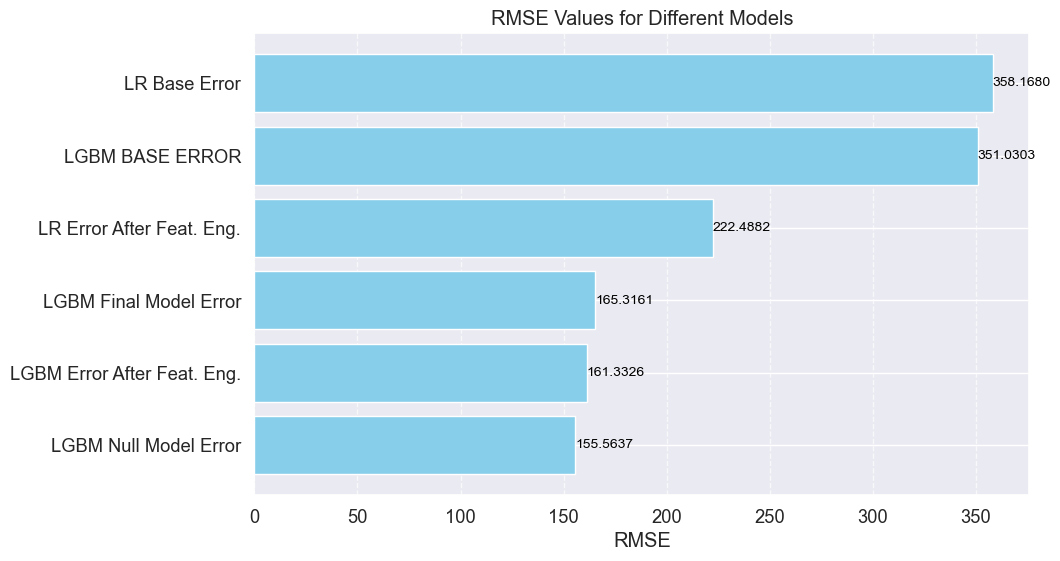

In [38]:
plt.figure(figsize=(10,6))
bars = plt.barh(score_df['Model'], score_df['RMSE'], color='skyblue')

# Çubukların üstüne RMSE değerlerini ekleyelim
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.4f}', va='center', ha='left', fontsize=10, color='black')

plt.xlabel('RMSE')
plt.title('RMSE Values for Different Models')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.show()

In [39]:
import pickle
pickle.dump(null_tuned_model, open("null_tuned_model.pkl", 'wb'))


In [40]:
null_tuned_model = pickle.load(open('null_tuned_model.pkl', 'rb'))
prediction = null_tuned_model.predict(X_test)
print("Tahmin Sonucu:", prediction)

Tahmin Sonucu: [ 384.79750814  100.1097993   189.15853838  675.20475932  551.27595052
  176.91873051  457.01872296  457.46984496  704.25502523  756.68454246
  875.12128196  324.88675917   79.7481793  1003.70975069   42.32885299
  631.98593174  434.23378087  219.44180442  132.93029721  515.89263201
  446.35722311  625.33066043  120.80542351  236.23332338  168.81316982
  404.1764026   649.45565795  403.10357271  223.66924145  284.1954422
  165.44595042  195.49821492 1109.85231972  213.39344773  878.18576663
  152.31733244   82.53458401  140.99397193  800.08577233  147.03647166
  172.77932973  220.15360894  719.84247326  612.94258336  789.37930647
  296.07603346  640.92960655  446.23993859  467.10574205  111.08306005]


In [41]:
prediction.shape

(50,)

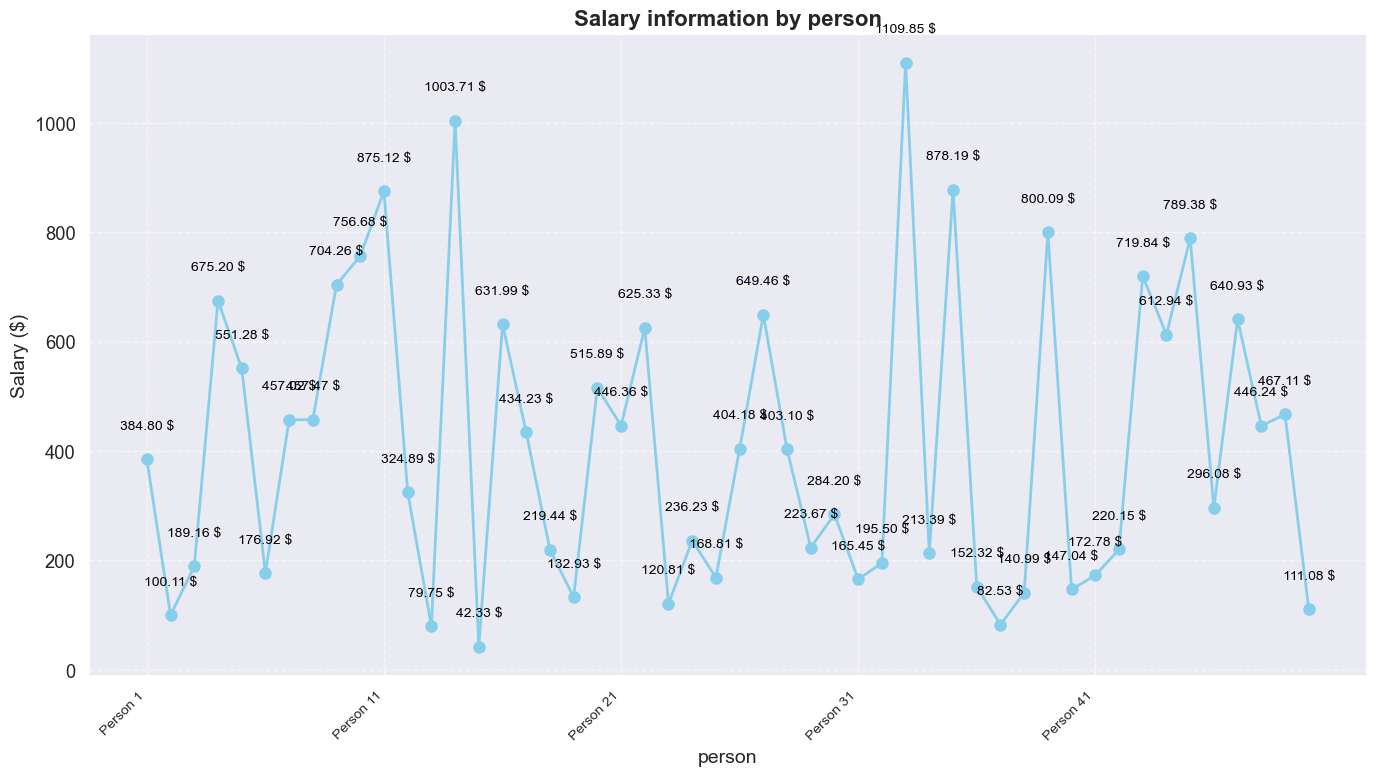

In [42]:
# DataFrame'e dönüştürme
df = pd.DataFrame(prediction, columns=["Maaş"])

# Kişi isimlerini otomatik olarak oluşturma
df['person'] = [f'person {i+1}' for i in range(len(df))]

# Grafik oluşturma
plt.figure(figsize=(14, 8))  # Grafik boyutunu daha büyük yapma

# X eksenini her 5 kişiden birini gösterelim
plt.plot(df['person'], df['Maaş'], marker='o', linestyle='-', color='skyblue', markersize=8, linewidth=2)

# Başlık ve etiketler
plt.title("Salary information by person", fontsize=16, fontweight='bold')
plt.xlabel("person", fontsize=14)
plt.ylabel("Salary ($)", fontsize=14)

# Her bir veri noktasının üzerine değerleri yazma (virgülden sonra 2 basamağı göstermek için formatlama)
for i, value in enumerate(df['Maaş']):
    plt.text(i, value + 50, f'{value:.2f} $', ha='center', va='bottom', fontsize=10, color='black')

# X ekseni etiketlerini döndürme
plt.xticks(rotation=45, ha='right', fontsize=10)

# X eksenindeki etiketlerin arasını açmak için her 5. kişiyi göstermek
plt.xticks(np.arange(0, len(df), step=10), labels=[f'Person {i+1}' for i in range(0, len(df), 10)])

# Grid ekleme (daha net bir görünüm)
plt.grid(True, linestyle='--', alpha=0.6)

# Grafik düzenlemesi
plt.tight_layout()

# Görselleştirmeyi gösterme
plt.show()
